In [1]:
import os
import re
import sys
import glob
import shutil
import numpy as np
import pandas as pd
from scipy import sparse, io
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc

In [2]:
matplotlib.rcParams.update({'font.size': 12})
# %config InlineBackend.figure_format = 'retina'
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html
# https://eleozzr.github.io/desc/tutorial.html

In [46]:
# cmd params
arg_keys = {
    'work_dir': "--work_dir=",
}
args = dict()
for argv in sys.argv[1:]:
    for k, arg_key in arg_keys.items():
        if argv.find(arg_key) == 0:
            args[k] = argv[len(arg_key):]

In [3]:
# ### /** Windows operation system **/
# work_dir = 'D:/Document/Programming/Python/deepbio/symphony/github/scanalysis/scqqapy/data/h5/sarcoma/'
# args = dict()
# args['work_dir'] = work_dir
# args['data_work_dir'] = work_dir
# args['fig_work_dir'] = work_dir

# ### /** Linux operation system **/
args['data_work_dir'] = args['work_dir'] + 'scanpy_integ_3_filter.dir/'
args['fig_work_dir'] = args['work_dir'] + 'scanpy_integ_3_filter_fig.dir/'

In [4]:
# read
adata = sc.read_h5ad(args['work_dir'] + 'scanpy_integ_2_chr.dir/adata_chr_unfilt.h5ad')
print(adata.obs['sample'].value_counts())

119291-CCS-72-snRNAseq_S4    9886
119288-CCS-07-snRNAseq_S1    7631
119290-CCS-15-snRNAseq_S3    7622
119289-CCS-08-snRNAseq_S2    7484
Name: sample, dtype: int64


## Filtering

In [5]:
def console(adata):
    print('remaining cells: {}, remaining genes: {}'.format(adata.X.shape[0], adata.X.shape[1]))
    
def saveTo(old_fn='scatter', new_fn='stat_basic', kind='.pdf'):
    os.replace(os.path.join(os.getcwd(), 'figures/' + old_fn + kind), os.path.join(os.getcwd(), 'figures/' + new_fn + kind))
    shutil.move(os.path.join(os.getcwd(), 'figures/' + new_fn + kind), args['fig_work_dir'] + new_fn + kind)
    shutil.rmtree(os.path.join(os.getcwd(), 'figures'))

In [6]:
# filter cells->genes and genes->cells by convention
console(adata)
sc.pp.filter_cells(adata, min_genes=200)
console(adata)
sc.pp.filter_genes(adata, min_cells=3)
console(adata)

remaining cells: 32623, remaining genes: 61552
remaining cells: 32623, remaining genes: 61552
filtered out 27012 genes that are detected in less than 3 cells
remaining cells: 32623, remaining genes: 34540


In [7]:
# filter mitochondria
adata = adata[adata.obs.pct_mito < 0.03]
console(adata)
# filter ribosome
adata = adata[adata.obs.pct_ribo > 0.05]
console(adata)

remaining cells: 32623, remaining genes: 34540
remaining cells: 12018, remaining genes: 34540


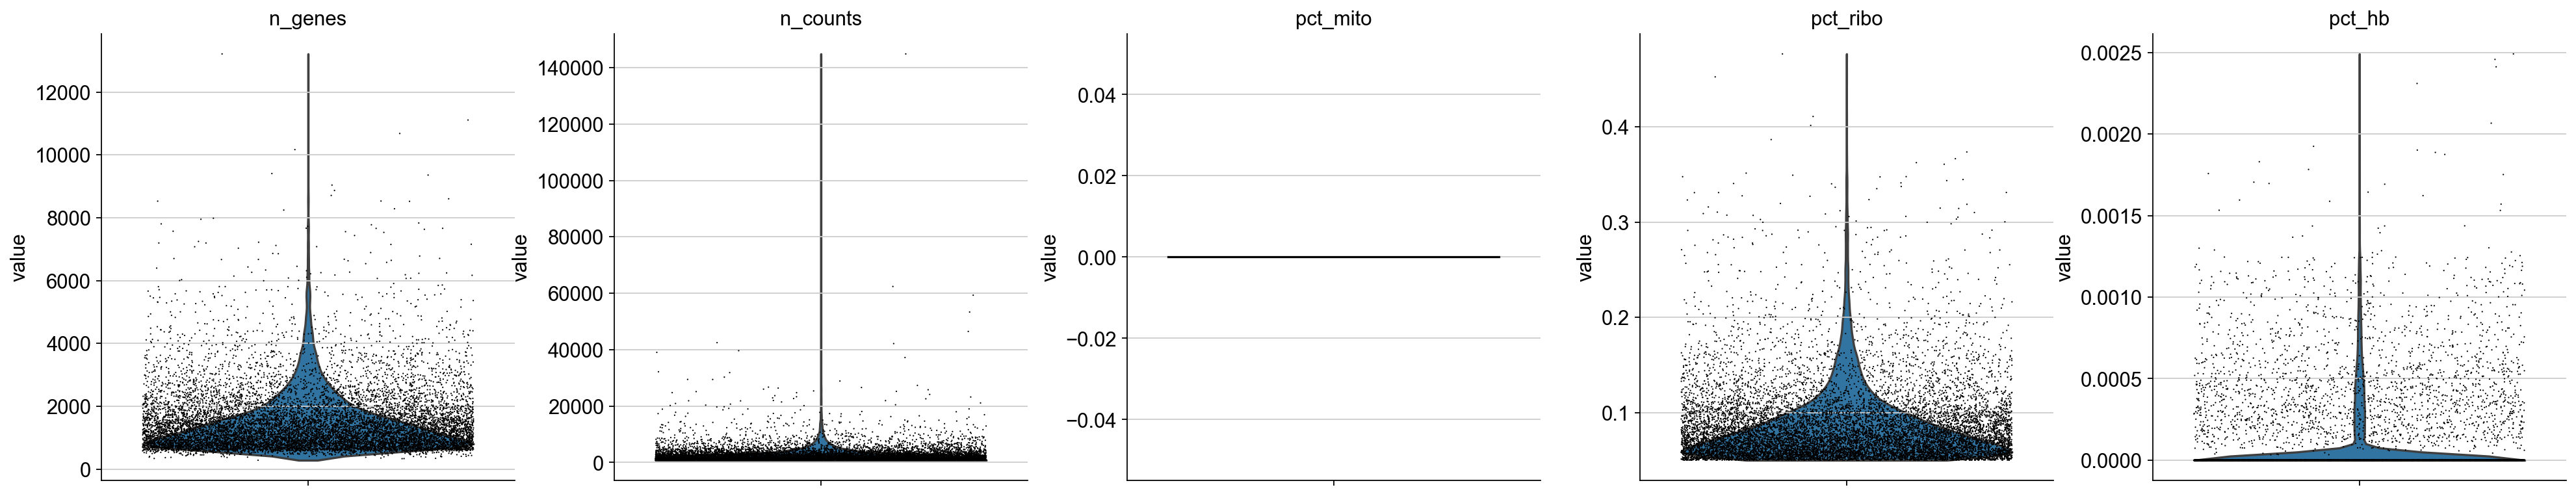

In [8]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'pct_mito', 'pct_ribo', 'pct_hb'], jitter=0.4, multi_panel=True, save='.pdf')
saveTo(old_fn='violin', new_fn='stat_basic', kind='.pdf')

In [9]:
cell_cycle_url = "https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt"
cell_cycle_genes = pd.read_csv(cell_cycle_url, comment='>')
cell_cycle_genes.columns = ['gene_name']
cell_cycle_genes
cell_cycle_genes = pd.Index(cell_cycle_genes['gene_name']).intersection(pd.Index(adata.var['gene_name']))
cell_cycle_genes
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_gene_ensembl = adata.var.loc[adata.var['gene_name'].isin(s_genes)].index
g2m_gene_ensembl = adata.var.loc[adata.var['gene_name'].isin(g2m_genes)].index
s_gene_ensembl

Index(['ENSG00000092853.14', 'ENSG00000162607.13', 'ENSG00000143476.18',
       'ENSG00000117748.10', 'ENSG00000132780.17', 'ENSG00000174371.17',
       'ENSG00000119969.15', 'ENSG00000170312.17', 'ENSG00000129173.13',
       'ENSG00000077514.9', 'ENSG00000168496.4', 'ENSG00000167325.15',
       'ENSG00000076248.11', 'ENSG00000198056.15', 'ENSG00000111247.15',
       'ENSG00000012963.15', 'ENSG00000051180.17', 'ENSG00000092470.12',
       'ENSG00000197299.13', 'ENSG00000075131.10', 'ENSG00000131153.9',
       'ENSG00000094804.12', 'ENSG00000136492.10', 'ENSG00000176890.16',
       'ENSG00000276043.5', 'ENSG00000095002.15', 'ENSG00000076003.5',
       'ENSG00000171848.16', 'ENSG00000144354.15', 'ENSG00000132646.11',
       'ENSG00000159259.8', 'ENSG00000093009.11', 'ENSG00000073111.14',
       'ENSG00000164104.12', 'ENSG00000163950.13', 'ENSG00000118412.13',
       'ENSG00000112312.10', 'ENSG00000049541.11', 'ENSG00000136982.6',
       'ENSG00000156802.13', 'ENSG00000175305.18', 'ENSG00

In [10]:
adata_cp = adata.copy()
adata_cp

AnnData object with n_obs × n_vars = 12018 × 34540
    obs: 'type', 'sample', 'batch', 'n_counts', 'pct_ribo', 'pct_hb', 'pct_mito', 'pct_chrY', 'cnt_XIST', 'n_genes'
    var: 'gene_name', 'n_cells'
    uns: 'sample_colors'

In [11]:
# normalize
# adata.raw = None
# adata.raw = adata
sc.pp.normalize_per_cell(adata_cp, counts_per_cell_after=1e4)
sc.pp.log1p(adata_cp)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


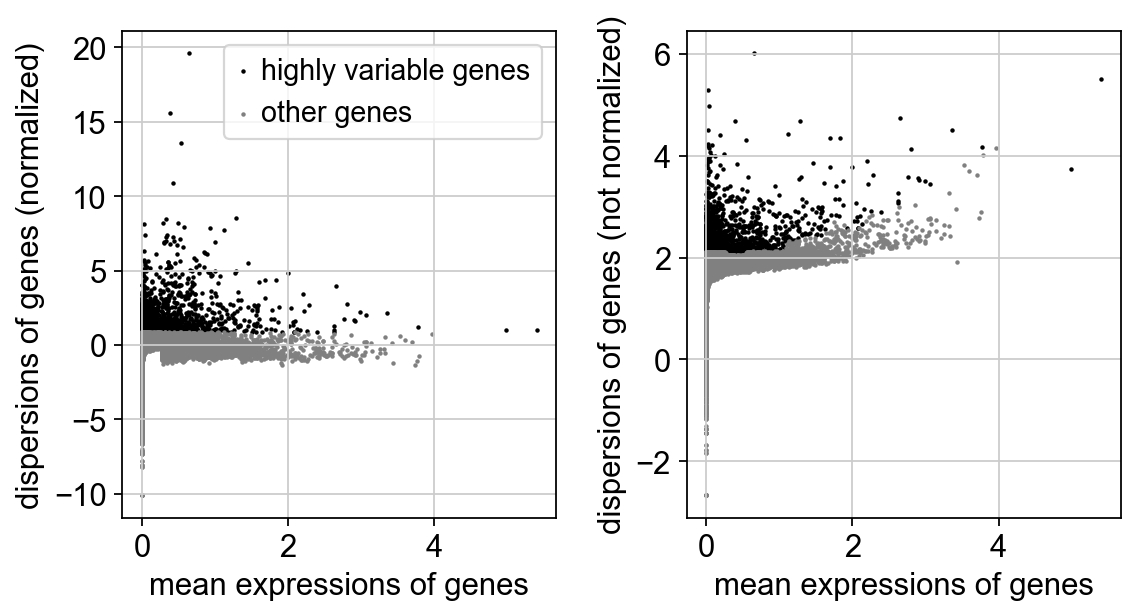

In [12]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata_cp, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata_cp, save='.pdf')
saveTo(old_fn='filter_genes_dispersion', new_fn='filter_genes_dispersion', kind='.pdf')

In [13]:
sc.pp.scale(adata_cp, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [14]:
sc.tl.score_genes_cell_cycle(adata_cp, s_genes=s_gene_ensembl, g2m_genes=g2m_gene_ensembl)

calculating cell cycle phase
computing score 'S_score'


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\tools\_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'S_score', score of gene set (adata.obs).
    515 total control genes are used. (0:00:02)
computing score 'G2M_score'


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scanpy\tools\_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'G2M_score', score of gene set (adata.obs).
    602 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


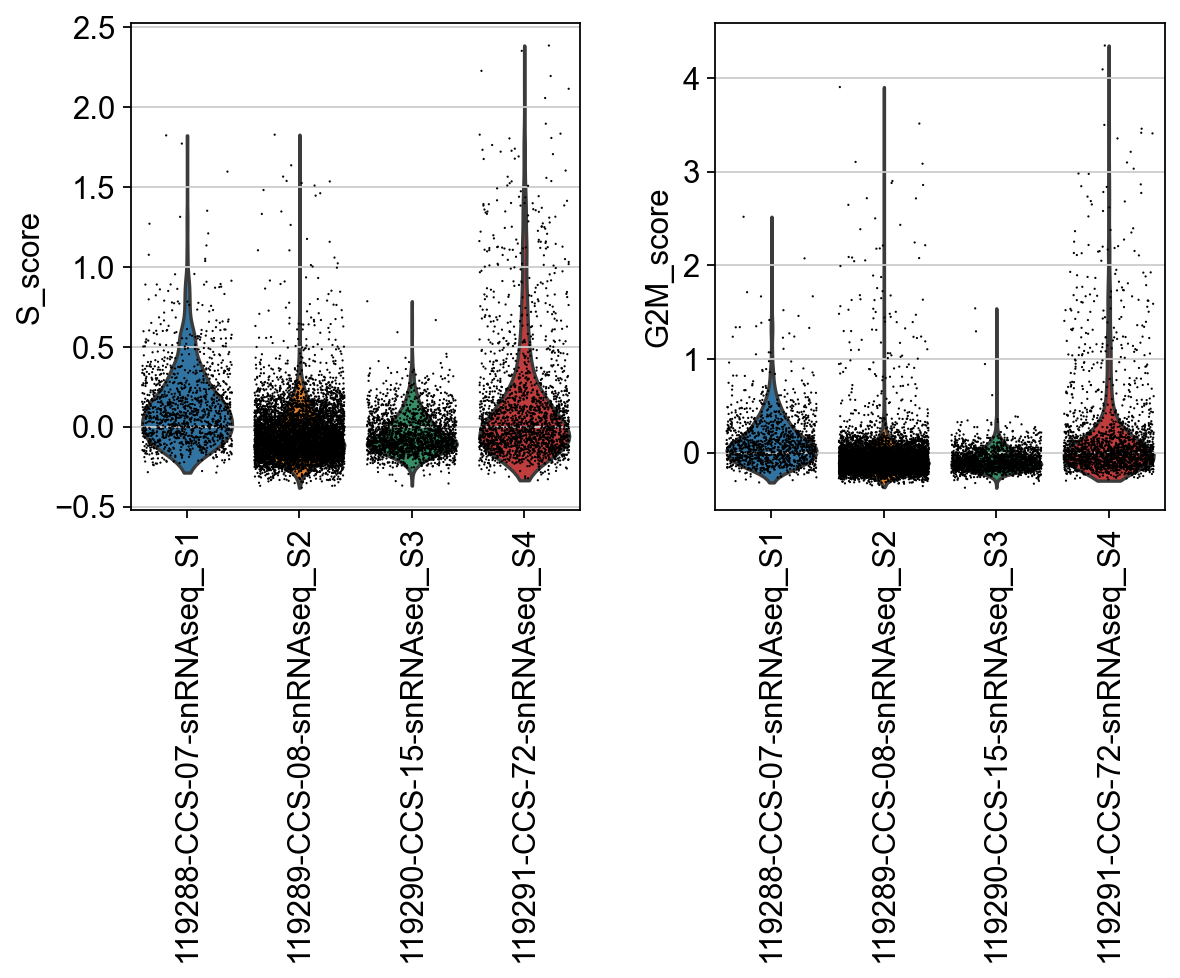

In [15]:
sc.pl.violin(adata_cp, ['S_score', 'G2M_score'], jitter=0.4, groupby = 'sample', rotation=90, save='.pdf')
saveTo(old_fn='violin', new_fn='cell_cycle_genes', kind='.pdf')

In [20]:
adata.obs['S_score'], adata.obs['G2M_score'], adata.obs['phase'] = adata_cp.obs['S_score'], adata_cp.obs['G2M_score'], adata_cp.obs['phase']

C:\Users\jianf\AppData\Local\Temp\ipykernel_1656\2245198199.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'], adata.obs['G2M_score'], adata.obs['phase'] = adata_cp.obs['S_score'], adata_cp.obs['G2M_score'], adata_cp.obs['phase']


In [26]:
del(adata_cp)

In [28]:
adata.write(args['data_work_dir'] + 'adata_filt.h5ad')